In [7]:
config='CALEDO60'
case='TRPC12N00'
year='2012'

In [8]:
# General and file management
import numpy as np
import numpy.ma as ma
import xarray as xr
from netCDF4 import Dataset
import dask.array as da

#For the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.ticker as mticker

import cartopy
cartopy.config['pre_existing_data_dir'] = '/scratch/cnt0024/hmg2840/albert7a/DEV/git/cartopy_data'
import cartopy.crs as ccrs
import cmocean

import warnings
warnings.filterwarnings('ignore')

#Jupyter magics
%matplotlib inline

In [9]:
# Request ressource
import multiprocessing.popen_spawn_posix
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
c = Client(cluster)
c

Client Scheduler: tcp://127.0.0.1:39895 Dashboard: http://127.0.0.1:43722/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [10]:
# Open data and mask
ds=xr.open_dataset('/scratch/cnt0024/ige2071/aalbert/'+config+'/'+config+'-'+case+'-MEAN/1y/'+year+'/'+config+'-'+case+'_1y_'+year+'_gridT-2D.nc',chunks={'x':1000,'y':500})
if config == 'CALEDO60':
    dscoord=xr.open_dataset('/store/brodeau/TROPICO12/TROPICO12.L125-I/NST/1_coordinates_TROPICO12.nc')
    dsmask=xr.open_dataset('/store/brodeau/TROPICO12/TROPICO12.L125-I/NST/1_mesh_mask_TROPICO12_L125_tr21.nc',drop_variables={'x','y'})
if config == 'TROPICO12':
    dscoord=xr.open_dataset('/store/brodeau/TROPICO12/TROPICO12.L125-I/coordinates_TROPICO12.nc')
    dsmask=xr.open_dataset('/store/brodeau/TROPICO12/TROPICO12.L125-I/mesh_mask_TROPICO12_L125_tr21_UPDATED.nc',drop_variables={'x','y'})


In [11]:
# Generic plot 
def plot_surf(ax, proj, var, cmap,vmin,vmax,label,title):
    ax.coastlines()
    if config == 'CALEDO60':
        gl=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), xlocs=[158,160,162,164,166,168,170,172])
    if config == 'TROPICO12':
        ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), xlocs=[120,140,160,180,200,220,240,260,280])
        gl=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), xlocs=[120,140,160,180,-160,-140,-120,-100,-80])

    gl.ylabels_right = False
    cs = plt.pcolormesh(dscoord.nav_lon-cm, dscoord.nav_lat, var,transform=proj,cmap=cmap,
                    vmin=vmin,vmax=vmax)
    cbar = plt.colorbar(cs,orientation='vertical',shrink=0.5,label='deg C')
    ax.set_title(title)


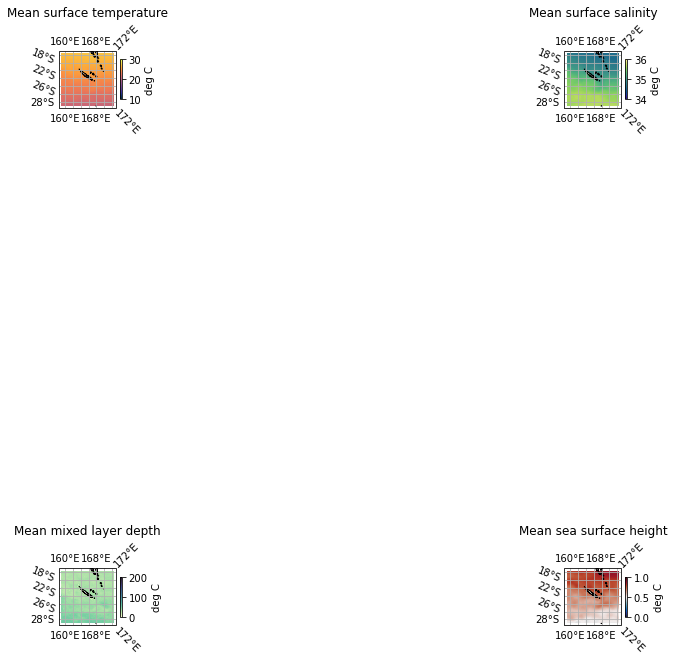

In [19]:
# Make plots of every surface mean fields
cm = 180
proj = ccrs.PlateCarree(central_longitude=cm)

fig = plt.figure(figsize=[10,10])
#plt.suptitle(config+' '+case+' '+year, y=1.05)

ax = fig.add_subplot(2, 2, 1, projection=proj)
tmean_surf=ds.tos[0]
tmask_surf=dsmask.tmask[0,0]
tmeansurf_mask=ma.masked_where(tmask_surf==0.,tmean_surf)
plot_surf(ax, proj, tmeansurf_mask, cmocean.cm.thermal,10,30,'deg C',
                  'Mean surface temperature')

ax = fig.add_subplot(2, 2, 2, projection=proj)
smean_surf=ds.sos[0]
smeansurf_mask=ma.masked_where(tmask_surf==0.,smean_surf)
plot_surf(ax, proj, smeansurf_mask, cmocean.cm.haline,34,36,'PSU',
                  'Mean surface salinity')

ax = fig.add_subplot(2, 2, 3, projection=proj)
mldmean=ds.mldr10_1[0]
mldmean_mask=ma.masked_where(tmask_surf==0.,mldmean)
plot_surf(ax, proj, mldmean_mask, cmocean.cm.deep,0,200,'m',
                  'Mean mixed layer depth')

ax = fig.add_subplot(2, 2, 4, projection=proj)
sshmean=ds.zos[0]
sshmean_mask=ma.masked_where(tmask_surf==0.,sshmean)
plot_surf(ax, proj, sshmean_mask, cmocean.cm.balance,0,1,'m',
                  'Mean sea surface height')

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
plt.tight_layout()
plt.savefig('plots/'+config+'-'+case+'_maps_surface_fields_'+year+'.png', bbox_inches='tight')